# SRE Agent

In [103]:
from dotenv import load_dotenv
import os
# Get the path to the root directory of the repository
root_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))

# Load environment variables from .env file in the root directory
load_dotenv(os.path.join(root_dir, '.env'), verbose=True)

True

In [104]:
import sys

# Add MCP-server to path
mcp_server_path = os.path.abspath(os.path.join(os.getcwd(), '../../MCP-server'))
sys.path.insert(0, mcp_server_path)

In [105]:
from langchain_openai import ChatOpenAI

gpt5mini = ChatOpenAI(model="gpt-5-mini")

## 1. Triage Agent

Gather a high-level overview of the cluster's health and identify potential problem areas.

In [106]:
from pydantic import BaseModel, Field
from typing import List, Literal

class Symptom(BaseModel):
    """A symptom observed in the Kubernetes cluster"""
    potential_symptom: str = Field(..., description="Type of symptom observed")
    resource_type: Literal["pod", "service"] = Field(..., description="Type of resource experiencing the issue")
    affected_resource: str = Field(..., description="Exact name of the resource experiencing the issue (no namespace or decorators)")
    evidence: str = Field(..., description="Evidence supporting this symptom identification")

class SymptomList(BaseModel):
    """A list of symptoms observed in the Kubernetes cluster"""
    symptoms: List[Symptom] = Field(default_factory=list, description="List of symptoms observed in the cluster")

In [107]:
from typing import TypedDict, List, Literal, Annotated

class TriageAgentState(TypedDict):
    app_name: str
    app_summary: str
    target_namespace: str
    trace_service_starting_point: str
    problematic_pods: dict
    problematic_traces: dict
    slow_traces: dict
    problematic_metrics: dict
    symptoms: List[Symptom]

In [108]:
from api.jaeger_api import JaegerAPI
from api.k8s_api import K8sAPI
from api.prometheus_api import PrometheusAPI

def get_triage_data(state: TriageAgentState):
    """Get triage data from cluster"""

    jaeger_api = JaegerAPI()
    k8s_api = K8sAPI(state["target_namespace"])
    prometheus_api = PrometheusAPI(namespace=state["target_namespace"])
    
    # Get pods with problematic statuses
    problematic_pods = k8s_api.get_problematic_pods()

    # Traces which have errors
    problematic_traces = jaeger_api.get_processed_traces(service=state["trace_service_starting_point"], only_errors=True)

    # Filtern for traces whxich take more than 2 seconds
    slow_traces = jaeger_api.get_slow_traces(service=state["trace_service_starting_point"], min_duration_ms=2000)

    # Metrics with anomalous values
    problematic_pods_metrics = {}
    problematic_pods_metrics["problematic_metrics"] = []

    pods = k8s_api.get_pods_list()

    for pod in pods:
        triage_metric_report = prometheus_api.get_pod_triage_metrics(pod)
        if triage_metric_report["is_anomalous"]:
            problematic_pods_metrics["problematic_metrics"].append(triage_metric_report)
    
    if(len(problematic_pods_metrics["problematic_metrics"])>0):
        problematic_pods_metrics["pods_count"] = len(problematic_pods_metrics["problematic_metrics"])
    else:
        problematic_pods_metrics["info"] = "All monitored metrics look healthy; no anomalous values detected."

    return {
        "problematic_pods": problematic_pods,
        "problematic_traces": problematic_traces,
        "slow_traces": slow_traces,
        "problematic_metrics": problematic_pods_metrics
    }

In [109]:
from pydantic import BaseModel, Field
from typing import List

class Symptom(BaseModel):
    """
    A symptom observed in the Kubernetes cluster
    """
    potential_symptom: str = Field(..., description="Type of symptom observed")
    resource_type: Literal["pod", "service"] = Field(..., description="Type of resource experiencing the issue")
    affected_resource: str = Field(..., description="Name of the resource experiencing the issue")
    evidence: str = Field(..., description="Evidence supporting this symptom identification")

class SymptomList(BaseModel):
    """
    A list of symptoms observed in the Kubernetes cluster
    """
    symptoms: List[Symptom] = Field(default_factory=list, description="List of symptoms observed in the cluster")

In [110]:
llm_for_symptoms = gpt5mini.with_structured_output(SymptomList)

In [111]:
import json
from langchain_core.prompts import ChatPromptTemplate

prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert Site Reliability Engineer. Your mission is to triage a Kubernetes application by analyzing the provided data.

Your analysis must adhere to the following rules:
1.  **Focus**: Identify symptoms at the **pod or service level only**. Do not provide cluster-wide analysis or generalizations.
2.  **Aggregation**: For each pod or service that has issues, create **at most one symptom entry**. Aggregate all related evidence (from pods, metrics, traces) into that single entry.
3.  **Action**: Synthesize the information to identify and list potential symptoms. For each symptom, pinpoint the affected resource (pod or service) and cite the specific evidence.
4.  **Resource Naming**: In the `affected_resource` field, provide ONLY the exact resource name without any decorators, prefixes, or namespace qualifiers (e.g., use "geo-6b4b89b5f5-rsrh7" NOT "test-hotel-reservation/geo-6b4b89b5f5-rsrh7").
5.  **Empty State**: If the provided data contains no issues, it is correct to return an empty list of symptoms.""",
        ),
        ("human", "{human_input}"),
    ]
)

In [112]:
def triage_agent(state: TriageAgentState):
    human_prompt_parts = [
    f"Please analyze the following triage data for the {state["app_name"]} application.\n\n### Application Summary\n{state["app_summary"]}"
    ]

    if "info" not in state["problematic_pods"]:
        problematic_pods_str = json.dumps(state["problematic_pods"], indent=2)
        human_prompt_parts.append(f"### Problematic Pods\n```json\n{problematic_pods_str}\n```")

    if "info" not in state["problematic_metrics"]:
        problematic_metrics_str = json.dumps(state["problematic_metrics"], indent=2)
        human_prompt_parts.append(f"### Anomalous Pod Metrics\n```json\n{problematic_metrics_str}\n```")

    if "info" not in state["problematic_traces"] and "error" not in state["problematic_traces"]:
        problematic_traces_str = json.dumps(state["problematic_traces"], indent=2)
        human_prompt_parts.append(f"### Error Traces\n```json\n{problematic_traces_str}\n```")

    if "info" not in state["slow_traces"] and "error" not in state["slow_traces"]:
        slow_traces_str = json.dumps(state["slow_traces"], indent=2)
        human_prompt_parts.append(f"### Slow Traces\n```json\n{slow_traces_str}\n```")
    
    # If no problems were found in any dataset, add a note.
    if len(human_prompt_parts) == 1:
        human_prompt_parts.append("No issues were found in pods, metrics, or traces.")

    human_input = "\n\n".join(human_prompt_parts)

    triage_chain = prompt_template | llm_for_symptoms

    symptom_list = triage_chain.invoke({
        "human_input" : human_input
    })

    return {"symptoms" : symptom_list.symptoms} #type: ignore

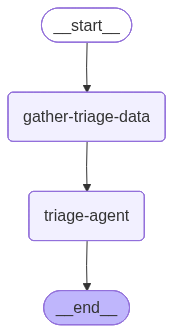

In [113]:
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display

# Build the graph
builder = StateGraph(TriageAgentState)

# Add nodes
builder.add_node("gather-triage-data", get_triage_data)
builder.add_node("triage-agent", triage_agent)

# Add edges
builder.add_edge(START,"gather-triage-data")
builder.add_edge("gather-triage-data", "triage-agent")
builder.add_edge("triage-agent", END)

triage_agent_graph = builder.compile().with_config(run_name="Triage Agent")

display(Image(triage_agent_graph.get_graph(xray=True).draw_mermaid_png()))

## 2. Planner agent

The Planner Agent acts as the strategic core of the RCA workflow. It receives all identified symptoms from the Triage Agent and performs a holistic analysis to identify correlations and potential causal links. Based on this analysis, it generates a unified, de-duplicated, and prioritized investigation plan, which is then distributed to parallel RCA Workers for execution. This centralized planning step transforms the diagnostic process from a reactive to a strategic operation, significantly improving efficiency and accuracy.

In [114]:
class RCATask(BaseModel):
    """A RCA task to be performed by the RCA agent"""
    investigation_goal: str = Field(..., description="Goal of the investigation")
    target_resource: str = Field(..., description="Name of the resource to investigate")
    resource_type: Literal["pod", "service"] = Field(..., description="Type of resource being investigated")
    suggested_tools: List[str] = Field(default_factory=list, description="List of tools suggested for the investigation")

class RCATaskList(BaseModel):
    "A list of RCA tasks o be performed by the RCA agent in parallel"
    rca_tasks: List[RCATask] = Field(default_factory=list, description="List of RCA tasks to be performed")

In [115]:
from typing import TypedDict, List, Literal, Annotated

class PlannerAgentState(TypedDict):
    app_name: str
    app_summary: str
    target_namespace: str
    symptoms: List[Symptom]
    rca_tasks: List[RCATask]

In [116]:
from api.k8s_api import K8sAPI
from api.datagraph import DataGraph

def get_resource_dependencies(symptom: Symptom) -> dict:

    result = {}
    result["resource_name"] = symptom.affected_resource
    result["resource_type"] = symptom.resource_type

    service = ""

    k8s_api = K8sAPI()

    if symptom.resource_type == "pod":
        services = k8s_api.get_services_from_pod(symptom.affected_resource)
        service =  services["services"][0]["service_name"]
    else:
        service = symptom.affected_resource

    datagraph = DataGraph()
    
    data_dependencies = datagraph.get_services_used_by(service)
    infra_dependencies = datagraph.get_dependencies(service)

    if len(data_dependencies) > 0:
        result["data_dependencies"] = []
        for dep in data_dependencies:
            temp = {}
            temp["service"] = dep
            pods = k8s_api.get_pods_from_service(dep)
            temp["pods"] = []
            for pod in pods["pods"]:
                temp["pods"].append(pod["pod_name"])
            result["data_dependencies"].append(temp)

    if isinstance(infra_dependencies, dict) and len(infra_dependencies) > 0:
        result["infra_dependencies"] = []
        for dep_name, dep_type in infra_dependencies.items():
            dep = {}
            dep["service"] = dep_name
            dep["dependency_type"] = dep_type
            dep["pods"] = []
            pods = k8s_api.get_pods_from_service(dep_name)
            for pod in pods["pods"]:
                dep["pods"].append(pod["pod_name"])
            result["infra_dependencies"].append(dep)   
    return result

In [117]:
llm_for_tasks = gpt5mini.with_structured_output(RCATaskList)

In [118]:
import json
from langchain_core.prompts import ChatPromptTemplate

planner_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert Site Reliability Engineer planning RCA investigations.

Your task is to analyze identified symptoms and create a list of RCA tasks for parallel execution.

**Available Tools:**

*Kubernetes Inspection:*
- kubectl_get: Get/list Kubernetes resources
- kubectl_describe: Describe resource details
- get_pods_from_service: Get pods belonging to a service
- get_cluster_pods_and_services: Get cluster overview

*Observability & Dependencies:*
- get_logs: Retrieve pod/service logs
- get_traces: Get traces with error filtering
- get_trace: Get detailed trace by ID
- get_metrics: Get current metrics (CPU, memory, network)
- get_metrics_range: Get historical metrics
- get_services_used_by: Get downstream service dependencies
- get_dependencies: Get infrastructure dependencies (databases, etc.)

**Guidelines:**
1. Each task should target ONE specific resource and investigation area
2. Suggest tools most likely to reveal the root cause based on symptom type
3. De-duplicate: if multiple symptoms share a resource, investigate that resource ONCE
4. Prioritize by likelihood of revealing root cause:
   - Pod crashes/errors → get_logs, kubectl_describe, get_metrics
   - High latency → get_traces, get_services_used_by, get_metrics
   - Connectivity issues → get_services_used_by, get_dependencies, kubectl_describe

**Task Format:**
- investigation_goal: Clear, specific goal (what to investigate and why)
- target_resource: The specific resource name (ONLY the exact name, no namespace or other prefixes)
- resource_type: "pod" or "service"
- suggested_tools: List of relevant tools (start with most impactful)

**IMPORTANT: Resource Names**
- Provide ONLY the exact resource name in `target_resource`
- Do NOT include namespace prefix (e.g., use "geo-6b4b89b5f5-rsrh7" NOT "test-hotel-reservation/geo-6b4b89b5f5-rsrh7")
- Do NOT include any other qualifiers or decorations
""",
        ),
        ("human", "{human_input}"),
    ]
)

In [119]:
def planner_agent(state: PlannerAgentState):
    """Create RCA investigation tasks from symptoms and their dependencies"""
    
    symptoms = state["symptoms"]
    
    if not symptoms:
        return {"rca_tasks": []}
    
    # Enrich symptoms with dependencies
    enriched_symptoms = []
    for symptom in symptoms:
        enriched = {
            "symptom": symptom.model_dump(),
            "dependencies": get_resource_dependencies(symptom)
        }
        enriched_symptoms.append(enriched)
    
    # Build human prompt with all symptom information in markdown format
    human_parts = []
    human_parts.append(f"# Application Context\n\n")
    human_parts.append(f"- **Application**: {state['app_name']}\n")
    human_parts.append(f"- **Namespace**: `{state['target_namespace']}`\n")
    human_parts.append(f"- **Summary**: {state['app_summary']}\n\n")
    human_parts.append("---\n\n")
    human_parts.append("# Symptoms to Investigate\n\n")
    
    for i, enriched in enumerate(enriched_symptoms, 1):
        symptom_dict = enriched["symptom"]
        deps = enriched["dependencies"]
        
        human_parts.append(f"## Symptom {i}\n\n")
        human_parts.append(f"**Type**: {symptom_dict['potential_symptom']}\n\n")
        human_parts.append(f"**Resource**: `{symptom_dict['affected_resource']}` (`{symptom_dict['resource_type']}`)\n\n")
        human_parts.append(f"**Evidence**:\n{symptom_dict['evidence']}\n\n")
        
        # Add dependencies if they exist
        if "data_dependencies" in deps and deps["data_dependencies"]:
            human_parts.append(f"**Data Dependencies**:\n```json\n{json.dumps(deps['data_dependencies'], indent=2)}\n```\n\n")
        
        if "infra_dependencies" in deps and deps["infra_dependencies"]:
            human_parts.append(f"**Infrastructure Dependencies**:\n```json\n{json.dumps(deps['infra_dependencies'], indent=2)}\n```\n\n")
        
        if "data_dependencies" not in deps and "infra_dependencies" not in deps:
            human_parts.append("**Dependencies**: None found\n\n")
        
        human_parts.append("---\n\n")
    
    human_input = "".join(human_parts)
    
    # Create and invoke chain
    planner_chain = planner_prompt_template | llm_for_tasks
    task_list = planner_chain.invoke({"human_input": human_input})
    
    return {"rca_tasks": task_list.rca_tasks} # type: ignore


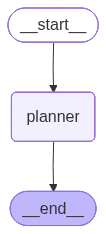

In [120]:
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display

# Build the planner graph
builder = StateGraph(PlannerAgentState)
builder.add_node("planner", planner_agent)
builder.add_edge(START, "planner")
builder.add_edge("planner", END)

planner_agent_graph = builder.compile().with_config(run_name="Planner Agent")



# Visualize
display(Image(planner_agent_graph.get_graph(xray=True).draw_mermaid_png()))


## 3. RCA Agent (Worker)

This agent acts as a tactical executor within the overall diagnostic workflow. It is not responsible for the full RCA, but for executing a single, specific investigation task (e.g., "check logs for pod X") assigned to it by the Planner Agent.

It runs in parallel with other workers, uses its tools to gather evidence for its assigned task, and then returns a concise diagnostic report. These reports are then collected and synthesized by the Supervisor Agent to determine the final root cause.

In [121]:
from langchain_mcp_adapters.client import MultiServerMCPClient

mcp_client = MultiServerMCPClient(
    {
        "kubernetes" : {
            "command": "npx",
            "args": ["mcp-server-kubernetes"],
            "transport": "stdio",
            "env": {
                "ALLOW_ONLY_NON_DESTRUCTIVE_TOOLS": "true"
            }
        },
        "cluster_api" : {
            "url": "http://localhost:8000/mcp",
            "transport": "streamable_http"
        }
    }
)

mcp_tools = await mcp_client.get_tools()

In [122]:
# Tools allowed
k8s_tools_allowed = ["kubectl_get", "kubectl_describe", "explain_resource", "list_api_resources", "ping"]
custom_tools_allowed = ["get_metrics", "get_metrics_range", "get_pods_from_service", "get_cluster_pods_and_services", "get_services_used_by", "get_dependencies", "get_logs", "get_traces", "get_trace"]

tools_allowed = k8s_tools_allowed + custom_tools_allowed

tools = []
for tool in mcp_tools:
    if tool.name in tools_allowed:
        tools.append(tool)

In [123]:
from pydantic import BaseModel, Field
from typing import TypedDict, Literal, Annotated, List
import operator

class RCATask(BaseModel):
    """A RCA task to be performed by the RCA agent"""
    investigation_goal: str = Field(..., description="Goal of the investigation")
    target_resource: str = Field(..., description="Name of the resource to investigate")
    resource_type: Literal["pod", "service"] = Field(..., description="Type of resource being investigated")
    suggested_tools: List[str] = Field(default_factory=list, description="List of tools suggested for the investigation")


In [124]:
from typing import List
from langgraph.graph.message import add_messages, AnyMessage

class RcaAgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    rca_app_summary: str 
    rca_target_namespace: str
    rca_task: RCATask
    insights: Annotated[list[str], operator.add]
    prev_steps: Annotated[list[str], operator.add]
    rca_output: dict
    rca_analyses_list: list[dict]

In [125]:
class UpdateAgentData(BaseModel):
    """
    Represents a step performed by the SRE agent.
    """
    insight: str = Field(..., description="Most important new finding")
    prev_step: str = Field(..., description="Concise description of the most recent action taken")

In [126]:
rca_agent_prompt = """
Developer: You are an expert DevOps engineer performing focused Root Cause Analysis on a Kubernetes service.

Service: {app_summary}

Investigation Task:
- **Goal**: {investigation_goal}
- **Target**: {resource_type} named '{target_resource}' (namespace {target_namespace})
- **Priority Tools**: {suggested_tools}

INVESTIGATION BUDGET: Maximum {investigation_budget} tool calls. Use only what is strictly necessary—avoid redundant or unnecessary queries. You have already made **{tool_calls_count}** tool calls out of {investigation_budget}.

{budget_status}

Investigation Context:
*Previous Steps:* {prev_steps}
*Insights:* {insights}

Instructions:
1. Use ONLY the Priority Tools above, which are specifically pre-selected for this investigation. Do not propose or use tools outside this list.
2. For each tool call, first formulate a clear, testable hypothesis about a possible root cause that can be answered by the result. Avoid broad or exploratory queries.
3. Each tool call must provide unique, non-overlapping information. Never repeat requests with similar parameters or investigate the same aspect repeatedly in slightly different ways.
4. Stop investigating, even if you have not reached {investigation_budget} calls, when you have:
   - Clear evidence that directly identifies a root cause (or definitively rules one out)
   - Multiple data points indicating the same failure/cause
   - Sufficient information to answer the investigation goal
5. DO NOT:
   - Repeat or re-run tools unless you are testing a truly new and justified hypothesis
   - Query outside the given Target or Priority Tools
   - Investigate unrelated resources or expand scope
6. When you have gathered sufficient, non-redundant evidence (typically after 2-3 targeted tool calls), call submit_final_diagnosis with:
   - diagnosis: State the precise root cause as it pertains to the investigation goal
   - reasoning: Support your diagnosis by referencing unique findings from your tool calls

Special constraints:
- You will not see the raw results of your tool calls; instead, your summary will be extracted for highlights and steps. Therefore, make each step and summary explicit, clear, and concise.

REMEMBER: Quality over quantity. Focus on unique and conclusive findings rather than exhaustive or repetitive investigation.
"""

In [127]:
summarise_prompt = """
    You are an autonomous SRE agent performing Root Cause Analysis on a Kubernetes incident.

    Context:

    Previous Insights: 
    {insights}
    
    Previous Steps:
    {prev_steps}

    Below are the latest messages (tool calls and/or tool responses - may include parallel executions):
    {last_messages}

    Instructions:
    1. **Extract the key insight**: Identify the most important NEW finding from all the latest messages that helps diagnose the root cause. Focus on:
       - Anomalies or unusual patterns
       - Resource states that could cause issues
       - Dependencies or relationships discovered
       - Error messages or failure indicators
       - Patterns across multiple tool responses (in case of parallel calls)
       If the tool calls failed or returned no useful data, note this as the insight.
    
    2. **Describe the actions taken**: Write a concise description of what tools were called and what resources were examined.
       Format: "Checked [resource/metric] using [tool_name]" (list all tools if multiple parallel calls)
       Example for parallel: "Checked pod logs and dependencies using get_logs and get_dependencies"

    Keep both responses under 150 characters each. Be specific and actionable.
"""

In [128]:
def get_insights_str(state):
    """Return a string with the formatted list of insights gathered during exploration"""
    if len(state["insights"]) > 0:
        return "\n- ".join([""] + state["insights"])
    else:
        return "No insights yet"
    
def get_prev_steps_str(state):
    """Return a string with the formatted list of previous steps performed during exploration"""
    if len(state["prev_steps"]) > 0:
        return "\n- ".join([""] + state["prev_steps"])
    else:
        return "No previous steps yet"

In [129]:
llm_with_strct_output = gpt5mini.with_structured_output(UpdateAgentData)

In [130]:
from langchain_core.messages import HumanMessage, AIMessage

# Node used to summarise the infos given the latest messages (handles parallel tool calls)
async def summarise(state: RcaAgentState):

    # Gather all recent messages starting from the last AI message (tool calls)
    # and all subsequent tool responses
    messages = state["messages"]
    last_ai_idx = None
    
    # Find the last AI message (which contains tool calls)
    for i in range(len(messages) - 1, -1, -1):
        if isinstance(messages[i], AIMessage):
            last_ai_idx = i
            break
    
    # Collect messages from last AI message onwards (to capture all parallel responses)
    if last_ai_idx is not None:
        last_messages = messages[last_ai_idx:]
    else:
        last_messages = messages[-2:]  # Fallback to last 2 messages

    insights_str = get_insights_str(state)
    prev_step_str = get_prev_steps_str(state)

    prompt = HumanMessage(content=summarise_prompt.format(
        prev_steps = prev_step_str,
        insights=insights_str,
        last_messages=last_messages))

    data = llm_with_strct_output.invoke([prompt])

    return {"insights" : [data.insight], "prev_steps" : [data.prev_step]} #type: ignore

In [131]:
from typing import Annotated
from langgraph.types import Command
from langchain_core.messages import ToolMessage
from langchain_core.tools import tool, InjectedToolCallId

# Tool used to submit the final response
@tool
def submit_final_diagnosis(
    diagnosis: str, 
    reasoning: str,
    tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    """
    Submit the final diagnosis when investigation is complete.
    
    Args:
        diagnosis: The issue you have identified (without fixing it)
        reasoning: Your reasoning and thought process behind the diagnosis (keep it concise)
    
    Returns:
        Command to update state and end workflow
    """
    final_response = {
        "diagnosis" : diagnosis,
        "reasoning" : reasoning
    }
    
    return Command(
        update={
            "rca_output": final_response,
            "messages": [
                ToolMessage(
                    content="Final diagnosis submitted successfully. Investigation complete.",
                    tool_call_id=tool_call_id
                )
            ]
        },
        goto="format-output" # End the loop cycle
    )

In [132]:
# Append the tool for submission to the list of tools (MCP servers)
completion_tool = submit_final_diagnosis
tools_with_completion = tools + [completion_tool]

In [133]:
async def rcaAgent(state: RcaAgentState):
    
    # Count tool calls (excluding submit_final_diagnosis) [Budget enforcement]
    tool_call_count = 0
    for msg in state["messages"]:
        if isinstance(msg, AIMessage) and hasattr(msg, 'additional_kwargs'):
            if "tool_calls" in msg.additional_kwargs:
                for call in msg.additional_kwargs.get('tool_calls', []):
                    if "function" in call:
                        tool_name = call.get("function", {}).get("name", "")
                        if tool_name != "submit_final_diagnosis":
                            tool_call_count += 1
    
    MAX_TOOL_CALLS = int(os.environ.get("MAX_TOOL_CALLS", 8))

    insights_str = get_insights_str(state)
    prev_step_str = get_prev_steps_str(state)
    
    # Extract task details
    task = state["rca_task"]
    suggested_tools_str = ", ".join(task.suggested_tools) if task.suggested_tools else "Use your best judgment"

    # Build budget status message
    budget_status = ""
    if tool_call_count >= MAX_TOOL_CALLS:
        budget_status = f"""
⚠️ **BUDGET EXCEEDED**: You have made {tool_call_count}/{MAX_TOOL_CALLS} tool calls.

You MUST now call submit_final_diagnosis with your best conclusion based on the evidence gathered so far.
Do NOT make any more tool calls. Submit your diagnosis immediately.
"""
    elif tool_call_count >= MAX_TOOL_CALLS - 2:
        budget_status = f"""
⚠️ **BUDGET WARNING**: You have made {tool_call_count}/{MAX_TOOL_CALLS} tool calls. You should prepare to submit your diagnosis soon.
"""

    prompt = HumanMessage(content=rca_agent_prompt.format(
        prev_steps=prev_step_str, 
        insights=insights_str, 
        app_summary=state["rca_app_summary"],  # Updated field name
        target_namespace=state["rca_target_namespace"],  # Updated field name
        investigation_goal=task.investigation_goal,
        resource_type=task.resource_type,
        target_resource=task.target_resource,
        suggested_tools=suggested_tools_str,
        investigation_budget=MAX_TOOL_CALLS,
        tool_calls_count=tool_call_count,
        budget_status=budget_status
    ))

    llm_with_completion_tools = gpt5mini.bind_tools(tools_with_completion, parallel_tool_calls=False)
    return {"messages": [llm_with_completion_tools.invoke([prompt])]}

In [134]:
from langchain_core.messages import AIMessage
from collections import Counter

def count_tool_calls(messages):
    """
    Plots a bar chart of tool call occurrences by tool name from state['messages'].
    """
    # Extract tool names from ToolMessage objects
    tool_calls = []
    for msg in messages:
        if isinstance(msg, AIMessage):
            if hasattr(msg, 'additional_kwargs'):
                if "tool_calls" in msg.additional_kwargs:
                    for call in msg.additional_kwargs['tool_calls']:
                        if "function" in call:
                            if "name" in call["function"]:
                                tool_calls.append(call["function"]["name"])

    # Count occurrences
    counts = Counter(tool_calls)

    return dict(counts)

In [135]:
async def format_response(state: RcaAgentState):

    final_report = state["rca_output"]
    
    task = state["rca_task"]
    final_report["task"] = {
        "investigation_goal" : task.investigation_goal,
        "target_resource" : task.target_resource,
        "resource_type" : task.resource_type,
        "suggested_tools" : task.suggested_tools
    }
    
    final_report["insights"] = state["insights"]
    final_report["steps_performed"] = state["prev_steps"]
    final_report["tools_stats"] = count_tool_calls(state["messages"])

    return {"rca_analyses_list" : [final_report]}  # Return as a list

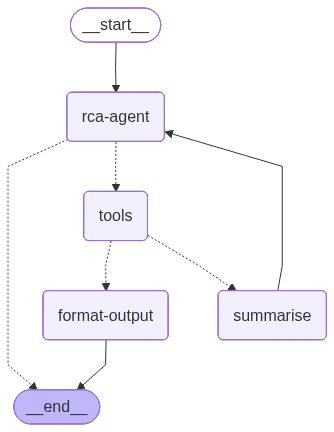

In [136]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Build the graph
builder = StateGraph(RcaAgentState)

# Add nodes
builder.add_node("rca-agent", rcaAgent)
builder.add_node("tools", ToolNode(tools_with_completion)) # Tool node is executing the tool called in the previous message
builder.add_node("summarise", summarise) # Node to reduce the raw data into a schema
builder.add_node("format-output", format_response)

# Add edges
builder.add_edge(START, "rca-agent")

# Conditional edge from sre-agent
builder.add_conditional_edges(
    "rca-agent",
    # Use in the conditional_edge to route to the ToolNode if the last message has tool calls. Otherwise, route to the end.
    tools_condition,
)

# After tools, decide whether to summarise or end
def after_tools_condition(state: RcaAgentState):
    # If rca_analyses_list is filled, investigation is complete (end of the workflow)
    if state.get("rca_analyses_list") and len(state["rca_analyses_list"]) > 0:
        analysis = state["rca_analyses_list"][0]
        if "diagnosis" in analysis and "reasoning" in analysis:
            return "format-output"
    return "summarise"

builder.add_conditional_edges(
    "tools",
    after_tools_condition,
    {
        "summarise": "summarise",
        "format-output": "format-output"
    }
)

# After summarise, continue investigation (go to rca-agent)
builder.add_edge("summarise", "rca-agent")
builder.add_edge("format-output", END)

# Compile the graph, returning only the rca_analyses_list field
rca_agent_graph = builder.compile().with_config(run_name="RCA Agent", output_keys=["rca_analyses_list"])


# Show the graph
display(Image(rca_agent_graph.get_graph(xray=True).draw_mermaid_png()))

## 4. Supervisor Agent

The Supervisor Agent is the final decision-making component of the RCA workflow. It receives and aggregates all the individual diagnostic reports from the parallel RCA Workers. Its core objective is to synthesize these fragmented findings, correlate information across different investigation tasks, and formulate a single, comprehensive root cause diagnosis for the entire incident. 

**TODO**: If the findings are inconclusive, it can also trigger a new planning cycle.

In [137]:
class FinalReport(BaseModel):
    """The Final report created by the supervisor agent"""
    root_cause: str = Field(..., description="The identified root cause of the incident")
    affected_resources: List[str] = Field(..., description="List of all resources affected by the incident")
    evidence_summary: str = Field(..., description="Summary of evidence from all RCA workers")
    investigation_summary: str = Field(..., description="Overview of the investigation process and findings")

In [138]:
from typing import TypedDict

class SupervisorAgentState(TypedDict):
    app_name: str
    app_summary: str
    symptoms: List[Symptom]
    rca_analyses_list: List[dict]
    final_report: dict

In [139]:
from langchain_openai import ChatOpenAI

gpt5mini = ChatOpenAI(model="gpt-5-mini")

llm_for_final_report = gpt5mini.with_structured_output(FinalReport)

In [140]:
import json
from langchain_core.prompts import ChatPromptTemplate

supervisor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert Site Reliability Engineer analyzing RCA findings to determine the root cause of an incident.

Analyze all symptoms and investigation findings to:
1. Identify patterns and correlations across findings
2. Determine the primary root cause
3. List all affected resources
4. Summarize key evidence

Provide a clear, specific root cause statement that explains what caused the incident.""",
        ),
        ("human", "{human_input}"),
    ]
)

In [141]:
def supervisor_agent(state: SupervisorAgentState):
    """Analyze all RCA findings and produce final root cause diagnosis"""
    
    symptoms = state.get("symptoms", [])
    rca_analyses = state.get("rca_analyses_list", [])
    app_summary = state.get("app_summary", "")
    app_name = state.get("app_name", "")
    
    if not rca_analyses and not symptoms:
        return {"final_report": FinalReport(
            root_cause="No analysis data available",
            affected_resources=[],
            evidence_summary="No symptoms or RCA analysis provided",
            investigation_summary="Investigation incomplete - insufficient data"
        ).model_dump()}
    
    # Build human prompt with all investigation data in markdown format
    human_parts = []
    human_parts.append(f"# Incident Analysis Summary\n\n")
    human_parts.append(f"- **Application**: {app_name}\n")
    human_parts.append(f"- **Summary**: {app_summary}\n\n")
    human_parts.append("---\n\n")
    
    # Add symptoms
    if symptoms:
        human_parts.append("# Symptoms Identified\n\n")
        for i, symptom in enumerate(symptoms, 1):
            human_parts.append(f"## Symptom {i}\n\n")
            human_parts.append(f"**Type**: {symptom.potential_symptom}\n\n")
            human_parts.append(f"**Resource**: `{symptom.affected_resource}` ({symptom.resource_type})\n\n")
            human_parts.append(f"**Evidence**: {symptom.evidence}\n\n")
        human_parts.append("---\n\n")
    
    # Add RCA analysis findings
    if rca_analyses:
        human_parts.append("# RCA Investigation Findings\n\n")
        for i, analysis in enumerate(rca_analyses, 1):
            human_parts.append(f"## Investigation {i}\n\n")
            human_parts.append(f"```json\n{json.dumps(analysis, indent=2)}\n```\n\n")
        human_parts.append("---\n\n")
    
    human_input = "".join(human_parts)
    human_input += "\n\nBased on all the above information, provide a comprehensive root cause diagnosis."
    
    # Create and invoke chain
    supervisor_chain = supervisor_prompt_template | llm_for_final_report
    final_report = supervisor_chain.invoke({"human_input": human_input})
    
    return {"final_report": final_report.model_dump()} #type: ignore

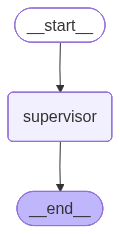

In [142]:
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display

# Build the supervisor graph
builder = StateGraph(SupervisorAgentState)
builder.add_node("supervisor", supervisor_agent)
builder.add_edge(START, "supervisor")
builder.add_edge("supervisor", END)

supervisor_agent_graph = builder.compile().with_config(run_name="Supervisor Agent")

# Visualize
display(Image(supervisor_agent_graph.get_graph(xray=True).draw_mermaid_png()))

## SRE Agent

In [143]:
class SreParentState(TypedDict):
    app_name: str
    app_summary: str
    target_namespace: str
    trace_service_starting_point: str

    # Triage Agent
    problematic_pods: dict
    problematic_traces: dict
    slow_traces: dict
    problematic_metrics: dict
    symptoms: List[Symptom]

    # Planner agent
    rca_tasks: List[RCATask]

    # RCA Worker agent
    rca_analyses_list: Annotated[list[dict], operator.add]

    # Supervisor agent
    final_report: dict

In [144]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
import operator  # Ensure operator is imported for Annotated

# --- FINAL FIX EXPLANATION ---
# Each parallel RCA agent returns {"rca_analyses_list": [analysis]} (a list with one analysis).
# The parent state aggregates these lists using operator.add, combining all analyses into rca_analyses_list.
# This ensures proper parallel execution without InvalidUpdateError.

# --- FIXED CODE ---
def rca_router(state: SreParentState) -> list[Send]:
    """Route to RCA agents for parallel execution, or skip to supervisor if no tasks"""
    rca_tasks = state.get("rca_tasks", [])

    if not rca_tasks:
        # No RCA tasks, go directly to supervisor with current symptoms
        supervisor_input = {
            "app_name": state.get("app_name"),
            "app_summary": state.get("app_summary"),
            "symptoms": state.get("symptoms", []),
            "rca_analyses_list": []
        }
        return [Send("supervisor_agent", supervisor_input)]

    parallel_rca_calls = []
    for task in rca_tasks:
        # Pass renamed fields to avoid InvalidUpdateError with parent state
        rca_input_state = {
            "rca_task": task,
            "rca_app_summary": state.get("app_summary", ""),  # Renamed field
            "rca_target_namespace": state.get("target_namespace", ""),  # Renamed field
            "messages": [],
            "insights": [],
            "prev_steps": [],
            "rca_analyses_list": []
        }
        parallel_rca_calls.append(Send("rca_agent", rca_input_state))

    return parallel_rca_calls

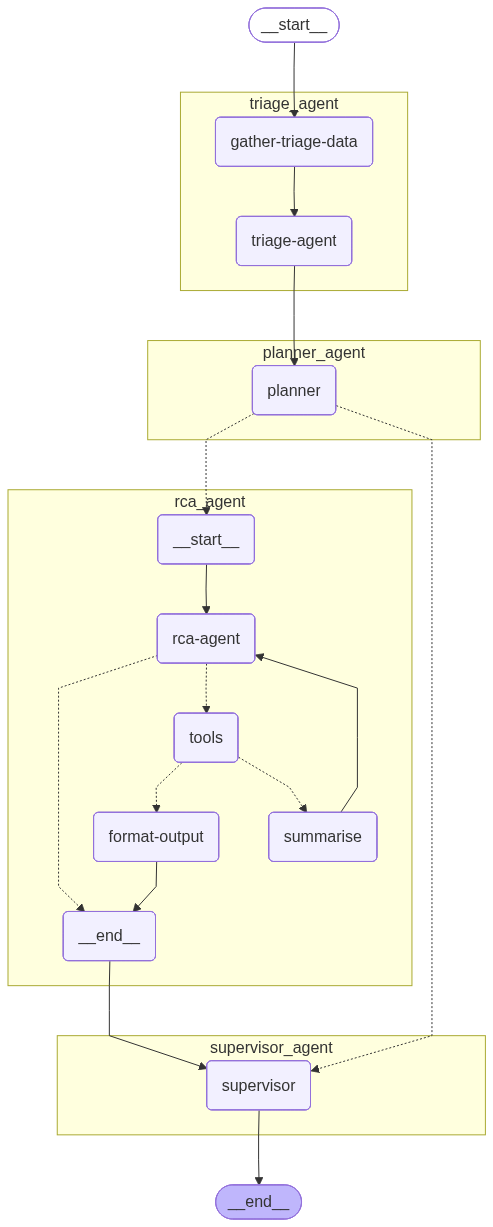

In [145]:
builder = StateGraph(SreParentState)

builder.add_node("triage_agent", triage_agent_graph)
builder.add_node("planner_agent", planner_agent_graph)
builder.add_node("rca_agent", rca_agent_graph)
builder.add_node("supervisor_agent", supervisor_agent_graph)

builder.add_edge(START, "triage_agent")
builder.add_edge("triage_agent", "planner_agent")

# Use rca_router to dynamically send tasks to parallel RCA agents
# or skip to supervisor if no tasks
builder.add_conditional_edges(
    "planner_agent", 
    rca_router,
    ["rca_agent", "supervisor_agent"]
)

# After RCA agents complete, go directly to supervisor (no collect_analyses needed)
builder.add_edge("rca_agent", "supervisor_agent")

builder.add_edge("supervisor_agent", END)

parent_graph = builder.compile()
Image(parent_graph.get_graph(xray=True).draw_mermaid_png())

In [146]:
import time

async def run_sre_agent(graph, app_name: str, app_summary: str, target_namespace: str, trace_service_starting_point: str, trace_name: str | None = None):
    """Test the SRE agent workflow"""
    
    initial_state = {
        "app_name": app_name,
        "app_summary": app_summary,
        "target_namespace": target_namespace,
        "trace_service_starting_point": trace_service_starting_point,
        "problematic_pods": {},
        "problematic_traces": {},
        "slow_traces": {},
        "problematic_metrics": {},
        "symptoms": [],
        "rca_tasks": [],
        "rca_analyses_list": [],  # Removed rca_analysis
        "final_report": {}
    }
    
    start_time = time.time()
    
    config = {"recursion_limit": 100}
    if trace_name:
        config["run_name"] = trace_name #type: ignore
    
    result = await graph.ainvoke(initial_state, config)
    
    execution_time = time.time() - start_time
    
    return result, execution_time

In [147]:
experiment_name = input("Enter experiment name: ")

if experiment_name.strip() == "":
    experiment_name = "SRE Agent Test"

In [148]:
app_summary = """
    The application implements a hotel reservation service, build with Go and gRPC. The initial project is extended in several ways, including adding back-end in-memory and persistent databases, adding a recommender system for obtaining hotel recommendations, and adding the functionality to place a hotel reservation. 
"""
target_namespace = "test-hotel-reservation"
service_starting_point = "frontend"

result, exec_time = await run_sre_agent(
    graph=parent_graph,
    app_name="Hotel reservation",
    app_summary=app_summary,
    target_namespace=target_namespace,
    trace_service_starting_point=service_starting_point,
    trace_name=experiment_name
)

print(f"\nExecution time: {exec_time:.2f} seconds")
print(f"\nFinal report:\n{result.get('final_report', {})}")


Execution time: 1269.52 seconds

Final report:
{'root_cause': 'Primary root cause: The geo service crashed and entered CrashLoopBackOff because its application was misconfigured to connect to MongoDB on port 27777 (mongodb-geo:27777) while the MongoDB service endpoints listen on port 27017. The geo process panicked with "no reachable servers" during DB initialization and exited with code 2, preventing the geo pod from becoming Ready and leaving the geo Service without endpoints. Contributing issues: (1) MongoDB was initialized with authentication enabled (--auth) by an init script, so even after correcting the port the geo client would need valid credentials; (2) the frontend->search gRPC "no connection available" errors are a separate, client-side service discovery/configuration issue (frontend Consul resolver / target mismatch) and not caused by the geo crash; (3) the rate service experienced a transient exit (Exit Code 2) but recovered and is not a persistent cause of the observed 

In [149]:
print(result["final_report"]["root_cause"])

Primary root cause: The geo service crashed and entered CrashLoopBackOff because its application was misconfigured to connect to MongoDB on port 27777 (mongodb-geo:27777) while the MongoDB service endpoints listen on port 27017. The geo process panicked with "no reachable servers" during DB initialization and exited with code 2, preventing the geo pod from becoming Ready and leaving the geo Service without endpoints. Contributing issues: (1) MongoDB was initialized with authentication enabled (--auth) by an init script, so even after correcting the port the geo client would need valid credentials; (2) the frontend->search gRPC "no connection available" errors are a separate, client-side service discovery/configuration issue (frontend Consul resolver / target mismatch) and not caused by the geo crash; (3) the rate service experienced a transient exit (Exit Code 2) but recovered and is not a persistent cause of the observed client errors.


In [156]:
len(result["rca_analyses_list"])

10

In [150]:
def export_json_results(result: dict) -> dict:

    export = result

    # Convert symptom pydantic objects to dict
    symptoms = []
    for s in result["symptoms"]:
        symptoms.append(s.model_dump())
    export["symptoms"] = symptoms

    # Convert rca_task pydantic objects to dict
    rca_tasks = []
    for t in result["rca_tasks"]:
        rca_tasks.append(t.model_dump())
    export["rca_tasks"] = rca_tasks
    
    return export

In [151]:
import json

with open("sre_agent_result-new.json", "w") as f:
    exported_json = export_json_results(result)
    json.dump(exported_json, f, indent=2, default=str)